In [1]:
import folium
from folium import plugins
import pandas as pd
import numpy as np
import json
import geopandas as gp
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geojson
import requests
import openpyxl

In [2]:
def coordToArray(geopdcoord):
    j = geopdcoord.replace("POINT (","") #remove palavra POINT (
    i = j.replace(")","").split(" ") # remove ultimo parenteses e splita o que sobrou resultando num array com as 2 coord
    ponto = Point(float(i[0]),float(i[1]))
    return ponto

In [ ]:
df = pd.read_excel("Georreferenciado.xlsx")

In [16]:
#transforma coluna de geocode em um array com objetos do tipo point
geopoint = []
for ponto in df["Geocode Novo"]:
    geopoint.append(coordToArray(ponto))

In [2]:
###### VERIFICAR SE PONTOS ESTÂO DENTRO DOS POLÍGONOS######################################################
cidades = {'municípios':['Porto Alegre',
                         'Canoas',
                         'Viamão',
                         'Cachoeirinha',
                         'Gravataí',
                         'São Leopoldo',
                         'Novo Hamburgo',
                         'Alvorada',
                         'Sapucaia do Sul',
                         'Guaíba',
                         'Eldorado do Sul',
                         'Esteio'],
           'código':[4314902,
                     4304606,
                     4323002,
                     4303103,
                     4309209,
                     4318705,
                     4313409,
                     4300604,
                     4320008,
                     4309308,
                     4306767,
                     4307708]}     
       
dfCodCidades =pd.DataFrame(cidades)

In [3]:
#configuração para acessar ibge
headers = {
    'Content-Type': 'application/json;charset=UTF-8',
    'User-Agent': 'google-colab',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
}
#loop para buscar shapes e armazenar em um DataFrame
arrayShapes = []
for cod in cidades['código']:
    #request via API ao site do IBGE
    shapes = requests.get("https://servicodados.ibge.gov.br/api/v2/malhas/"+str(cod)+"/?formato=application/vnd.geo+json&resolucao=5",
                              headers=headers)
    #atribui string json do shape para variável
    arrayShapes.append(Polygon(list(geojson.utils.coords(shapes.json()))))
    
dfCodCidades['ShapesIBGE'] = arrayShapes

In [220]:
dfCodCidades.head(1)

,municípios,código,ShapesIBGE
0,Porto Alegre,4314902,"POLYGON ((-51.2336 -29.9377, -51.2206 -29.967,..."
1,Canoas,4304606,"POLYGON ((-51.123 -29.8663, -51.106 -29.9024, ..."
2,Viamão,4323002,"POLYGON ((-50.9493 -29.9665, -50.9144 -30.0028..."
3,Cachoeirinha,4303103,"POLYGON ((-51.1012 -29.8687, -51.1008 -29.8692..."
4,Gravataí,4309209,"POLYGON ((-50.8121 -29.7742, -50.8139 -29.7842..."
5,São Leopoldo,4318705,"POLYGON ((-51.0681 -29.8112, -51.1367 -29.799,..."
6,Novo Hamburgo,4313409,"POLYGON ((-51.1346 -29.638, -51.1298 -29.6385,..."
7,Alvorada,4300604,"POLYGON ((-50.9493 -29.9665, -50.9624 -29.9901..."
8,Sapucaia do Sul,4320008,"POLYGON ((-51.1896 -29.7785, -51.1657 -29.7991..."
9,Guaíba,4309308,"POLYGON ((-51.3025 -30.054, -51.3125 -30.0858,..."


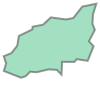

In [240]:
dfCodCidades.loc[dfCodCidades['municípios']=='Guaíba'].iloc[0][2] #teste

In [ ]:
#loop  para verificar se coordenadas estão dentro de um polígono
ajuste = []
for x, y in zip(df['Município'], df['Geocode Novo']):
    #procura no df na a coluna onde o o municipio é igual x e retorna o valor da terceira coluna que tem os Shapes do IBGE
    poly = dfCodCidades.loc[dfCodCidades['municípios']==x].iloc[0][2]
    #verifica se o ponto y  está n dentro do shape da cidade e adicona o resulatado em um array
    ajuste.append(poly.contains(coordToArray(y)))

In [ ]:
df['Ajustar Coordenadas'] = ajuste

In [248]:
with pd.ExcelWriter('Georreferenciado.xlsx', mode='a', engine='openpyxl') as writer: 
    df.to_excel(writer, sheet_name='CoordAdjust')